In [1]:
!pip install torchvision

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F

/Users/DELL/opt/anaconda3/envs/data-depth/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/DELL/opt/anaconda3/envs/data-depth/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CC4BC91F-8B6A-3F9A-B9EB-A2B9D578E202> /Users/DELL/opt/anaconda3/envs/data-depth/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <5310731F-64FC-310E-B88B-E06F64BB3F98> /Users/DELL/opt/anaconda3/envs/data-depth/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
class VAE(nn.Module):
    def __init__(
          self,
          x_dim,
          hidden_dim,
          z_dim=10
        ):
        super(VAE, self).__init__()

        # Define autoencoding layers
        self.enc_layer1 = nn.Linear(x_dim, hidden_dim)
        self.enc_layer2_mu = nn.Linear(hidden_dim, z_dim)
        self.enc_layer2_logvar = nn.Linear(hidden_dim, z_dim)

        # Define autoencoding layers
        self.dec_layer1 = nn.Linear(z_dim, hidden_dim)
        self.dec_layer2 = nn.Linear(hidden_dim, x_dim)

    def encoder(self, x):
        x = F.relu(self.enc_layer1(x))
        mu = F.relu(self.enc_layer2_mu(x))
        logvar = F.relu(self.enc_layer2_logvar(x))
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar/2)
        eps = torch.randn_like(std)
        z = mu + std * eps
        return z

    def decoder(self, z):
        # Define decoder network
        output = F.relu(self.dec_layer1(z))
        output = F.relu(self.dec_layer2(output))
        return output

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        output = self.decoder(z)
        return output, z, mu, logvar

# Define the loss function
def loss_function(output, x, mu, logvar):
    recon_loss = F.mse_loss(output, x, reduction='sum') / x.size(0)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + 0.002  * kl_loss


def train_model(
    model,
    dataloader,
    learning_rate=1e-4,
    # batch_size=128,
    num_epochs=15,
    # hidden_dim=256,
    # latent_dim=50
  ):
  # # Define the VAE model
  # model = VAE_simple(x_dim=X.shape[1], hidden_dim=hidden_dim, z_dim=latent_dim)

  # Define the optimizer
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  # # Convert X to a PyTorch tensor
  # X = torch.tensor(X).float()

  # # Create DataLoader object to generate minibatches
  # dataset = TensorDataset(X)
  # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  # Train the model
  for epoch in range(num_epochs):
      epoch_loss = 0
      for batch in dataloader:
          # Zero the gradients
          optimizer.zero_grad()

          # Get batch
          x = batch[0]

          # Forward pass
          output, z, mu, logvar = model(x)

          # Calculate loss
          loss = loss_function(output, x, mu, logvar)

          # Backward pass
          loss.backward()

          # Update parameters
          optimizer.step()

          # Add batch loss to epoch loss
          epoch_loss += loss.item()

      # Print epoch loss
      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader.dataset)}")

  return model

In [4]:
def load_test_data():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
    mnist_test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
    test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False)
    return test_loader


def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    with torch.no_grad():  # Disable gradient computation
        for batch in test_loader:
            x, _ = batch
            x = x.view(x.size(0), -1)  # Flatten the images

            # Forward pass
            output, z, mu, logvar = model(x)
            loss = loss_function(output, x, mu, logvar)
            test_loss += loss.item()

    test_loss /= len(test_loader.dataset)
    print(f"Test Loss: {test_loss}")

In [5]:
import matplotlib.pyplot as plt

def visualize_reconstruction(model, test_loader, num_images=10):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for batch in test_loader:
            x, _ = batch
            x = x.view(x.size(0), -1)  # Flatten the images

            # Forward pass
            output, _, _, _ = model(x)
            break  # We only need a single batch for visualization

    # Plot the original and reconstructed images
    x = x.view(-1, 28, 28)
    output = output.view(-1, 28, 28)
    fig, axes = plt.subplots(2, num_images, figsize=(15, 3))
    for i in range(num_images):
        axes[0, i].imshow(x[i].cpu().numpy(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(output[i].cpu().numpy(), cmap='gray')
        axes[1, i].axis('off')
    plt.show()

In [8]:
def main() :
  # Load MNIST dataset
  transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
  mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=False)
  dataloader = DataLoader(mnist_train, batch_size=128, shuffle=True)

  # Define the VAE model
  x_dim = 28 * 28  # MNIST images are 28x28
  hidden_dim = 256
  latent_dim = 50
  model = VAE(x_dim=x_dim, hidden_dim=hidden_dim, z_dim=latent_dim)

  trained_model = train_model(model, dataloader, learning_rate=1e-4, num_epochs=15)

  # Load test data
  test_loader = load_test_data()

  # Test the VAE model
  test_model(trained_model, test_loader)

  # Visualize reconstructions
  visualize_reconstruction(trained_model, test_loader, num_images=10)

  # train VAE to learn latent dimension
  # train it to be

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



4.0%

100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch 1/15, Loss: 0.4393286127726237
Epoch 2/15, Loss: 0.325615240351359
Epoch 3/15, Loss: 0.30156136938730876
Epoch 4/15, Loss: 0.28922326844533286
Epoch 5/15, Loss: 0.28071747824350995
Epoch 6/15, Loss: 0.27477201093037923
Epoch 7/15, Loss: 0.27015160818099976
Epoch 8/15, Loss: 0.2664688578923543
Epoch 9/15, Loss: 0.2634762767791748
Epoch 10/15, Loss: 0.26099502855936685
Epoch 11/15, Loss: 0.25868686841328936
Epoch 12/15, Loss: 0.2563245448748271
Epoch 13/15, Loss: 0.2548075313886007
Epoch 14/15, Loss: 0.25320262365341184
Epoch 15/15, Loss: 0.2516992502530416
Test Loss: 0.25147494983673097


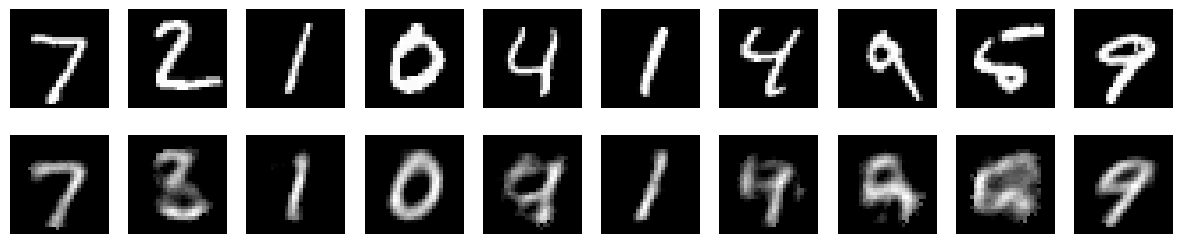

In [9]:
if __name__ == "__main__":
    main()